The given project is a classic example of the imbalanced binary-classification problem. What do we mean by imbalanced classification? This occurs when we have the response variable classified into various classes but the proportion of each of those varies significantly relative to one another. 

In our case, the class proportion for the class '1' is 0.85 while for class '0', it is 0.15. Hence, it can be easily deduced that the results generated by training our model on such a dataset would be highly biased towards the class '1'. 
- Therefore, we need to first address the imbalance. 
- Also, there are three categorical variables included in the dataset, we would need to address those by creating the dummy variables for those factor values in the categorical variable colums 

The best approach to use for a dataset like this where we have higher number of independent variables is to use decision trees but we would implement XGBoost to improve on the performance and the speed of the decision tree classifier.

# Kaggle name is "Clandestine"

In [41]:
import pandas as pd
import numpy as np
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Reading the train_data.csv into train dataframe and test_data.csv into test    dataframe

In [42]:


train = pd.read_csv("train_data.csv")
test = pd.read_csv("test_data.csv")

train.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,z217,z218,z219,z220,z221,z222,subject,phase,state,output
0,0,0,0,1,-300.361218,0.886360,-2.590886,225.001899,0.006204,0.000037,...,0.005242,0.024971,-1017.620978,-382.850838,-48.275711,-2.040336,A,3,B,0
1,0,0,0,1,-297.126090,0.622211,-3.960940,220.179017,0.006167,-0.000014,...,0.001722,0.023595,91.229094,24.802230,1.783950,0.022620,A,3,C,0
2,0,0,0,1,-236.460253,0.423640,-12.656341,139.453445,0.006276,-0.000028,...,-0.010894,-0.036318,-188.232347,-17.474861,-1.005571,-0.021628,A,3,B,0
3,0,0,0,1,33.411458,2.854415,-1.962432,3.208911,0.009752,-0.000273,...,-0.034184,-0.047734,185.122907,-549.282067,542.193381,-178.049926,A,3,A,0
4,0,0,0,1,-118.125214,2.009809,-3.291637,34.874176,0.007598,0.000001,...,0.001963,0.004084,35.207794,-78.143166,57.084208,-13.700212,A,4,C,0


# Plotting output variable of train data grouped per subject.

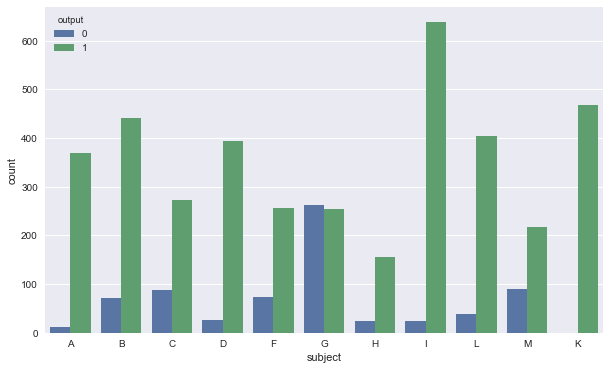

In [43]:
f, ax = plt.subplots(figsize=(10, 6))
sns.countplot(x="subject", hue="output", data=train);

# As you can see from the above plot, Subject K has only 1 as the output and also can be seen from the below output. Output "1" has appeared a total of 468 times when Subject is "K". 

# This is an important insight in terms of classifying the output of the test data-set because the training data shows that whenever the output was '1', the subject was always 'K'.

In [44]:
pd.Series(train[train.subject=='K']['output']).value_counts() 

1    468
Name: output, dtype: int64

# Creating column "indicator" in both train and test data frames with respective "train" values and "test" values. Also output feature of "train" dataframe is assigned to new dataframe "Y".

# The reason this is done is so that the preprocessing of training and test data can be done in one step only.

In [45]:
train['indicator'] = 'train'
test['indicator'] = 'test'

Y = train.output
train.drop('output',inplace = True, axis=1)

# Concatenating train and test data frames into train_test dataframe and resetting index.

In [46]:
train_test = pd.concat([train,test])
train_test.reset_index(inplace=True, drop=True)
train_test.shape

(6316, 670)

# Creating a dummy variable for Subject K as an independent feature

In [47]:
train_test['SubjectK'] = 0
train_test.loc[train_test[train_test.subject=='K'].index, 'SubjectK']=1

In [48]:
train_test.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,z218,z219,z220,z221,z222,subject,phase,state,indicator,SubjectK
0,0,0,0,1,-300.361218,0.886360,-2.590886,225.001899,0.006204,0.000037,...,0.024971,-1017.620978,-382.850838,-48.275711,-2.040336,A,3,B,train,0
1,0,0,0,1,-297.126090,0.622211,-3.960940,220.179017,0.006167,-0.000014,...,0.023595,91.229094,24.802230,1.783950,0.022620,A,3,C,train,0
2,0,0,0,1,-236.460253,0.423640,-12.656341,139.453445,0.006276,-0.000028,...,-0.036318,-188.232347,-17.474861,-1.005571,-0.021628,A,3,B,train,0
3,0,0,0,1,33.411458,2.854415,-1.962432,3.208911,0.009752,-0.000273,...,-0.047734,185.122907,-549.282067,542.193381,-178.049926,A,3,A,train,0
4,0,0,0,1,-118.125214,2.009809,-3.291637,34.874176,0.007598,0.000001,...,0.004084,35.207794,-78.143166,57.084208,-13.700212,A,4,C,train,0


# Creating columns related to "Phase" and "Subject" features and assigining values as 1 if a respective phase is 1 for the particular subject. Subject features can be from 'A' to 'K'.

# This feature engineering is employed to assess the interaction effect of the categorical variables. Interaction effect refers to the impact on the target/ ouput variable given two or more categorical variables act on the response variable in a simultaneous manner. 

In [50]:
#Step by step
i1 = train_test[((train_test.phase==1) & (train_test.subject=='A'))].index
arr = np.zeros(train_test.shape[0],dtype=int)
arr[i1]=1
train_test['SubA_Phase1']=arr


#concise
train_test['SubI_Phase1'] = 0
train_test.loc[train_test[((train_test.phase==1) & (train_test.subject=='I'))].index,'SubI_Phase1'] = 1

train_test['SubM_Phase1'] = 0
train_test.loc[train_test[((train_test.phase==1) & (train_test.subject=='M'))].index,'SubM_Phase1'] = 1

train_test['SubA_Phase2'] = 0
train_test.loc[train_test[((train_test.phase==2) & (train_test.subject=='A'))].index,'SubA_Phase2'] = 1

train_test['SubF_Phase2'] = 0
train_test.loc[train_test[((train_test.phase==2) & (train_test.subject=='F'))].index,'SubF_Phase2'] = 1

train_test['SubI_Phase3'] = 0
train_test.loc[train_test[((train_test.phase==3) & (train_test.subject=='I'))].index,'SubI_Phase3'] = 1

train_test['SubL_Phase3'] = 0
train_test.loc[train_test[((train_test.phase==3) & (train_test.subject=='L'))].index,'SubL_Phase3'] = 1

train_test['SubL_Phase4'] = 0
train_test.loc[train_test[((train_test.phase==4) & (train_test.subject=='L'))].index,'SubL_Phase4'] = 1
#possibly add I, phase4 = 1 too.

# Trying to create dummy variables for state, phase and subject features/columns by creating new columns related to them.

In [51]:
train_test['state'] = train_test['state'].map({'A':'StateA', 'B': 'StateB', 'C':'StateC','D':'StateD', 'E': 'StateE'})
train_test['phase'] = train_test['phase'].map({1:'phase1', 2: 'phase2', 3:'phase3',4:'phase4'})
train_test['subject'] = train_test['subject'].map({'A':'subjectA', 'B': 'subjectB', 'C':'subjectC',
                                                          'D':'subjectD', 'E': 'subjectE', 'F':'subjectF',
                                                          'G':'subjectG', 'H': 'subjectH', 'I':'subjectI',
                                                          'J':'subjectJ', 'K': 'subjectK'})
train_test.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,indicator,SubjectK,SubA_Phase1,SubI_Phase1,SubM_Phase1,SubA_Phase2,SubF_Phase2,SubI_Phase3,SubL_Phase3,SubL_Phase4
0,0,0,0,1,-300.361218,0.886360,-2.590886,225.001899,0.006204,0.000037,...,train,0,0,0,0,0,0,0,0,0
1,0,0,0,1,-297.126090,0.622211,-3.960940,220.179017,0.006167,-0.000014,...,train,0,0,0,0,0,0,0,0,0
2,0,0,0,1,-236.460253,0.423640,-12.656341,139.453445,0.006276,-0.000028,...,train,0,0,0,0,0,0,0,0,0
3,0,0,0,1,33.411458,2.854415,-1.962432,3.208911,0.009752,-0.000273,...,train,0,0,0,0,0,0,0,0,0
4,0,0,0,1,-118.125214,2.009809,-3.291637,34.874176,0.007598,0.000001,...,train,0,0,0,0,0,0,0,0,0


# Actually creating dummy variables

In [52]:
df_subject = pd.get_dummies(train_test['subject'])
df_phase = pd.get_dummies(train_test['phase'])
df_state = pd.get_dummies(train_test['state'])
print(df_phase.head())
print(df_state.head())
print(df_subject.head())

   phase1  phase2  phase3  phase4
0       0       0       1       0
1       0       0       1       0
2       0       0       1       0
3       0       0       1       0
4       0       0       0       1
   StateA  StateB  StateC  StateD  StateE
0       0       1       0       0       0
1       0       0       1       0       0
2       0       1       0       0       0
3       1       0       0       0       0
4       0       0       1       0       0
   subjectA  subjectB  subjectC  subjectD  subjectE  subjectF  subjectG  \
0         1         0         0         0         0         0         0   
1         1         0         0         0         0         0         0   
2         1         0         0         0         0         0         0   
3         1         0         0         0         0         0         0   
4         1         0         0         0         0         0         0   

   subjectH  subjectI  subjectJ  subjectK  
0         0         0         0         0  
1    

# Joining dummy data frame of "state feature" with dummy data frame of "phase feature" and in turn this would be joined with dummy data frame of "subject feature" and giving the name "new_df".

In [59]:
new_df = df_subject.join(df_state.join(df_phase))
new_df.head()

,subjectA,subjectB,subjectC,subjectD,subjectE,subjectF,subjectG,subjectH,subjectI,subjectJ,subjectK,StateA,StateB,StateC,StateD,StateE,phase1,phase2,phase3,phase4
0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
3,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


# Joining the new_df data frame created in the previous step with the original data frame "train_test"

In [54]:
train_test = train_test.join(new_df)
train_test.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,subjectK,StateA,StateB,StateC,StateD,StateE,phase1,phase2,phase3,phase4
0,0,0,0,1,-300.361218,0.886360,-2.590886,225.001899,0.006204,0.000037,...,0,0,1,0,0,0,0,0,1,0
1,0,0,0,1,-297.126090,0.622211,-3.960940,220.179017,0.006167,-0.000014,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,1,-236.460253,0.423640,-12.656341,139.453445,0.006276,-0.000028,...,0,0,1,0,0,0,0,0,1,0
3,0,0,0,1,33.411458,2.854415,-1.962432,3.208911,0.009752,-0.000273,...,0,1,0,0,0,0,0,0,1,0
4,0,0,0,1,-118.125214,2.009809,-3.291637,34.874176,0.007598,0.000001,...,0,0,0,1,0,0,0,0,0,1


# Creating train_1 and test_1 dataframes for training and testing out of train_test dataframe on the basis of the indicators created earlier. 

In [55]:
train_1 = train_test[train_test.indicator=='train']
test_1 = train_test[train_test.indicator=='test']
train_1.reset_index(inplace=True,drop=True)
test_1.reset_index(inplace=True,drop=True)

# Now dropping 'state', 'subject', 'phase', 'indicator' columns/features as we have already created dummy variables for them.

In [56]:
train_1 = train_1.drop(['state','subject','phase','indicator'], axis=1)
test_1 = test_1.drop(['state','subject','phase','indicator'], axis=1)



# Running XG Boost Classification model on the train_1 dataset 

In [57]:
#Create a model on complete training set 
model = xgb.XGBClassifier(seed=82, n_estimators=1100 , max_depth=3, colsample_bylevel=0.8,
                          colsample_bytree=0.7,learning_rate=0.01, reg_lambda=0.1 , 
                           scale_pos_weight = 0.18357862)

model.fit(train_1,Y, eval_metric='auc')
pred = model.predict(test_1) 
preds = model.predict_proba(test_1) #submit these predictions

In [58]:
submithis = pd.DataFrame([test_1.index,preds[:,1]]).T
submithis.columns = ['id','output']
submithis.id = submithis.id.astype(int)
submithis.to_csv('Pred_XGBoost_2.csv',index=False)

## Initial attempts - 

Algorithms : 
- Random Forest 
- Logistic Regression
- Naive Bayes

Steps to address the class imbalance in training dataset :
- Random over sampling
- Upsampling
- SMOTE <not effecicent in higher dimensional data, such as ours>

Evaluation Metrics :
- Confusion Metrics
- AUC curve
- F1 Score

## Random Forest

In [ ]:
raw_train_data = pd.read_csv("train_data.csv")
raw_train_data.head()

In [ ]:
coord = ['x','y','z']
cols_to_norm = []
for c in coord: 
    for dp in range(1,223):
        cols_to_norm.append(c+str(dp))

copy_raw_original_data = raw_train_data
copy_raw_original_data[cols_to_norm] = copy_raw_original_data[cols_to_norm].apply(lambda x: (x - x.mean()) / x.std())
copy_raw_original_data = copy_raw_original_data.fillna(0)
copy_raw_original_data.head()

In [ ]:
# This is second verison, we are using SMOTE here

from sklearn.utils import resample

df_majority = copy_raw_original_data[copy_raw_original_data.output==1]
df_minority = copy_raw_original_data[copy_raw_original_data.output==0]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=3873,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
print(df_upsampled.output.value_counts())

In [ ]:
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()

df_upsampled["subject"] = lb_make.fit_transform(df_upsampled["subject"])
df_upsampled["state"] = lb_make.fit_transform(df_upsampled["state"])

df_upsampled.head()

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_upsampled, test_size=0.2, random_state=123)

# from sklearn.preprocessing import LabelEncoder

# lb_make = LabelEncoder()
# train["subject"] = lb_make.fit_transform(train["subject"])
# train["state"] = lb_make.fit_transform(train["state"])

# test["subject"] = lb_make.fit_transform(test["subject"])
# test["state"] = lb_make.fit_transform(test["state"])

In [ ]:
train_features = train.loc[:, train.columns != 'output']
train_target = train.loc[:, train.columns == 'output']

test_features = test.loc[:, test.columns != 'output']
test_target = test.loc[:, test.columns == 'output']

print(train_features.head())
print(train_target.head())

In [83]:
# First classifier without oversampling the minority class in the training** dataset

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_jobs=2, random_state=0, class_weight="balanced")
clf.fit(train_features, train_target)

/Users/rkheruwa/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=2, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [84]:
# Predicting on test** dataset

preds = clf.predict(test_features)
pred_prob = clf.predict_proba(test_features)

In [85]:
# Create confusion matrix
pd.crosstab(test['output'], preds, rownames=['Actual output'], colnames=['Predicted output'])

Predicted output,0,1
Actual output,,
0,755,12
1,80,703


In [58]:
from sklearn.metrics import confusion_matrix
cm_LR = confusion_matrix(test_target, preds)
cm_LR

array([[755,  12],
       [ 80, 703]])

In [59]:
## Classification Report

import sklearn

print(sklearn.metrics.classification_report(test_target, preds, target_names = ["0", "1"]))

#####

from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(test_target, preds)

             precision    recall  f1-score   support

          0       0.90      0.98      0.94       767
          1       0.98      0.90      0.94       783

avg / total       0.94      0.94      0.94      1550



(array([ 0.90419162,  0.98321678]),
 array([ 0.98435463,  0.89782886]),
 array([ 0.94257179,  0.93858478]),
 array([767, 783]))

In [60]:
## precision recal curve

from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(test_target, preds)
print("precision_SVM : ", precision)
print("recall_SVM : ", recall)
print("thresholds_SVM : ", thresholds)

precision_SVM :  [ 0.50516129  0.98321678  1.        ]
recall_SVM :  [ 1.          0.89782886  0.        ]
thresholds_SVM :  [0 1]


In [61]:
## Roc_AUC Curve

from sklearn.metrics import roc_auc_score

roc_auc_score(test_target, preds)

0.94109174588426492

## Logistic Regression

In [13]:
# Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(train_features, train_target)

# Predicting the Test set results
y_pred_LR = classifier.predict(test_features)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_LR = confusion_matrix(test_target, y_pred_LR)
cm_LR

/Users/sonaliyadav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[557, 210],
       [243, 540]])

In [14]:
pd.crosstab(test['output'], y_pred_LR, rownames=['Actual output'], colnames=['Predicted output'])

Predicted output,0,1
Actual output,,
0,557,210
1,243,540


## Naive Bayes

In [16]:
# Fitting Naive Bayes to the Training set
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(train_features, train_target)

# Predicting the Test set results
y_pred_Naive_Bayes = classifier.predict(test_features)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_target, y_pred_Naive_Bayes)
cm

array([[718,  49],
       [628, 155]])

In [17]:
pd.crosstab(test['output'], y_pred_Naive_Bayes, rownames=['Actual output'], colnames=['Predicted output'])

Predicted output,0,1
Actual output,,
0,718,49
1,628,155


# Implementing the model on test data

In [55]:
raw_test_data = pd.read_csv("test_data.csv")

lb_make = LabelEncoder()
raw_test_data["subject"] = lb_make.fit_transform(raw_test_data["subject"])
raw_test_data["state"] = lb_make.fit_transform(raw_test_data["state"])

raw_test_data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,z216,z217,z218,z219,z220,z221,z222,subject,phase,state
0,0,0,0,1,-18.839131,2.306584,-4.655889,1.013324,0.007153,0.000055,...,0.002809,0.014684,0.008373,325.428102,-821.094825,689.695558,-192.867397,1,1,1
1,0,0,0,1,-21.203051,2.112956,-2.503654,1.233657,0.007674,0.000025,...,0.001450,-0.012349,-0.029579,377.365602,-943.446587,785.687687,-217.952016,1,1,2
2,0,0,0,1,-83.843508,2.097191,-2.625699,17.607247,0.007290,0.000077,...,-0.024253,-0.014029,-0.015090,564.866863,-1445.004242,1231.304590,-349.493698,1,1,2
3,0,0,0,1,-192.522878,0.605105,-2.468908,92.456149,0.006284,0.000007,...,0.019957,-0.037490,0.002925,-552.398720,1163.146256,-816.945306,191.395611,1,1,2
4,0,0,0,1,-188.095799,0.390008,-4.870923,88.257844,0.007859,-0.000058,...,0.007063,-0.007101,0.025921,-860.687432,1838.968578,-1310.372483,311.393705,1,1,2


In [56]:
## Test data normalization

test_coord = ['x','y','z']
cols_to_norm = []
for c in test_coord:
    for dp in range(1,223):
        cols_to_norm.append(c+str(dp))

copy_raw_original_testdata = raw_test_data
copy_raw_original_testdata[cols_to_norm] = copy_raw_original_testdata[cols_to_norm].apply(lambda x: (x - x.mean()) / x.std())
copy_raw_original_testdata = copy_raw_original_testdata.fillna(0)
copy_raw_original_testdata.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,z216,z217,z218,z219,z220,z221,z222,subject,phase,state
0,0.0,0.0,0.0,0.866505,1.672939,0.611541,0.178259,-1.767013,-0.545688,0.126154,...,0.064884,0.175049,0.080378,1.112484,-0.647184,0.921050,-0.481412,1,1,1
1,0.0,0.0,0.0,0.866505,1.657672,0.442779,0.683771,-1.765485,-0.526204,0.046310,...,0.048290,-0.126714,-0.281613,1.245096,-0.760331,1.017965,-0.559863,1,1,2
2,0.0,0.0,0.0,0.866505,1.253136,0.429039,0.655105,-1.651940,-0.540563,0.186707,...,-0.265419,-0.145473,-0.143413,1.723843,-1.224158,1.467871,-0.971252,1,1,2
3,0.0,0.0,0.0,0.866505,0.551278,-0.871437,0.691932,-1.132891,-0.578153,-0.001195,...,0.274170,-0.407363,0.028421,-1.128869,1.187790,-0.600091,0.720347,1,1,2
4,0.0,0.0,0.0,0.866505,0.579868,-1.058911,0.127752,-1.162005,-0.519300,-0.175807,...,0.116805,-0.068127,0.247759,-1.916023,1.812772,-1.098266,1.095634,1,1,2


In [57]:
preds = clf.predict(copy_raw_original_testdata)
preds
preds_df = pd.DataFrame(preds)
# preds_df.to_csv("pred_class.csv")

In [58]:
#preds_df = preds_df.reset_index()
#preds_df.columns = ['id', 'class']
preds_df
preds_df.to_csv("pred_class_1.csv")

In [62]:
pred_prob = clf.predict_proba(copy_raw_original_testdata)
pred_prob = pred_prob[:,1]

In [64]:
solution_MK = pd.DataFrame(pred_prob)
solution_MK.to_csv("pred_class_probability_2.csv")